# Laboratorio 4

#### Mario de León 19029
#### Javier Valle 20159

In [1]:
# Descripción de los datos, preprocesamiento y sus explicaciones, unigramas, bigramas, modelo preliminar de predicción.

"""
    Datos:
    id: Identificador del Tweet.
    keword: una palabra clave del tweet, puede estar en blanco.
    location: la ubicación desde donde fue enviado el tweet.
    text: el texto del tweet.
    target: indica si se trata de un desastre real (1) o no (0). 
"""

'\n    Datos:\n    id: Identificador del Tweet.\n    keword: una palabra clave del tweet, puede estar en blanco.\n    location: la ubicación desde donde fue enviado el tweet.\n    text: el texto del tweet.\n    target: indica si se trata de un desastre real (1) o no (0). \n'

### Inciso 2: Cargar los datos.

#### Imports necesarios.

In [12]:
import pandas as pd
import re
import nltk
from nltk import word_tokenize, bigrams
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# Cargar el dataset desde un archivo CSV
test = pd.read_csv('test.csv')

train = pd.read_csv("train.csv")

# Cargando las primeras 5 filas del dataset.
print("Test")
print(test.head())

print("Train")
print(test.head())

Test
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
Train
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
# Info del dataset.
print("Test")
print(test.info())

print("Train")
print(train.info())

Test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None
Train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


## Inciso 3: Limpie y preprocese los datos. Describa de forma detallada las activdades de preprocesamiento que llevó a cabo.

In [5]:
# Convertir el texto a mayúsculas o minúsculas.

# Convertiendo todas las columnas de texto a minúsculas del dataset test.
test = test.apply(lambda x: x.astype(str).str.lower() if x.dtype == "object" else x)

# Imprimiendo el DataFrame resultante
print(test)

# Convertiendo todas las columnas de texto a minúsculas del dataset train.
train = train.apply(lambda x: x.astype(str).str.lower() if x.dtype == "object" else x)

# Imprimiendo el DataFrame resultante
print(train)

         id keyword location   
0         0     nan      nan  \
1         2     nan      nan   
2         3     nan      nan   
3         9     nan      nan   
4        11     nan      nan   
...     ...     ...      ...   
3258  10861     nan      nan   
3259  10865     nan      nan   
3260  10868     nan      nan   
3261  10874     nan      nan   
3262  10875     nan      nan   

                                                   text  
0                    just happened a terrible car crash  
1     heard about #earthquake is different cities, s...  
2     there is a forest fire at spot pond, geese are...  
3              apocalypse lighting. #spokane #wildfires  
4         typhoon soudelor kills 28 in china and taiwan  
...                                                 ...  
3258  earthquake safety los angeles ûò safety faste...  
3259  storm in ri worse than last hurricane. my city...  
3260  green line derailment in chicago http://t.co/u...  
3261  meg issues hazardous weather 

#### Quitando caracteres especiales.

In [6]:
# Función para limpiar los caracteres especiales
def clean_text(text):
    if isinstance(text, str):
        # Eliminar caracteres no alfanuméricos excepto espacios
        cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        return cleaned_text
    else:
        return text

# Aplicando la función a todas las columnas de texto del df train.
train = train.applymap(clean_text)

# Imprimir df resultante
print(train)

# Aplicando la función a todas las columnas de texto del df test
test = test.applymap(clean_text)

# Imprimir df resultante
print(test)

         id keyword location   
0         1     nan      nan  \
1         4     nan      nan   
2         5     nan      nan   
3         6     nan      nan   
4         7     nan      nan   
...     ...     ...      ...   
7608  10869     nan      nan   
7609  10870     nan      nan   
7610  10871     nan      nan   
7611  10872     nan      nan   
7612  10873     nan      nan   

                                                   text  target  
0     our deeds are the reason of this earthquake ma...       1  
1                 forest fire near la ronge sask canada       1  
2     all residents asked to shelter in place are be...       1  
3     13000 people receive wildfires evacuation orde...       1  
4     just got sent this photo from ruby alaska as s...       1  
...                                                 ...     ...  
7608  two giant cranes holding a bridge collapse int...       1  
7609  ariaahrary thetawniest the out of control wild...       1  
7610  m194 0104 utc5k

#### Describiendo los datos

In [7]:
# Obteneniendo estadísticas sobre las longitudes de los textos en la columna "keyword"
train['tweet_length'] = train['keyword'].apply(len)  # Agregando una columna con las longitudes de los textos
text_stats = train['tweet_length'].describe()

# Obteneniedo la cantidad de categorías únicas en la columna "location"
location_unique_count = train['location'].nunique()

# Imprimiendo las estadísticas de longitud de textos y la cantidad de categorías únicas en la ubicación
print("Estadísticas de longitud de textos:\n", text_stats)
print("\nCantidad de categorías únicas en la ubicación:", location_unique_count)

# Obteneniendo estadísticas sobre las longitudes de los textos en la columna "keyword"
train['tweet_length'] = train['text'].apply(len)  # Agregando una columna con las longitudes de los textos
text_stats = train['tweet_length'].describe()

# Obteneniedo la cantidad de categorías únicas en la columna "location"
location_unique_count = train['location'].nunique()

# Imprimiendo las estadísticas de longitud de textos y la cantidad de categorías únicas en la ubicación
print("Estadísticas de longitud de textos:\n", text_stats)
print("\nCantidad de categorías únicas en base al texto:", location_unique_count)

Estadísticas de longitud de textos:
 count    7613.000000
mean        8.533824
std         3.208316
min         3.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        20.000000
Name: tweet_length, dtype: float64

Cantidad de categorías únicas en la ubicación: 3129
Estadísticas de longitud de textos:
 count    7613.000000
mean       93.899251
std        31.709694
min         6.000000
25%        71.000000
50%        99.000000
75%       123.000000
max       143.000000
Name: tweet_length, dtype: float64

Cantidad de categorías únicas en base al texto: 3129


In [8]:
# Obteneniendo estadísticas sobre las longitudes de los textos en la columna "keyword"
test['tweet_length'] = test['keyword'].apply(len)  # Agregando una columna con las longitudes de los textos
text_stats = train['tweet_length'].describe()

# Obteneniedo la cantidad de categorías únicas en la columna "location"
location_unique_count = test['location'].nunique()

# Imprimiendo las estadísticas de longitud de textos y la cantidad de categorías únicas en la ubicación
print("Estadísticas de longitud de textos:\n", text_stats)
print("\nCantidad de categorías únicas en la ubicación:", location_unique_count)

# Obteneniedo la cantidad de categorías únicas en la columna "location"
location_unique_count = test['location'].nunique()

# Imprimiendo las estadísticas de longitud de textos y la cantidad de categorías únicas en la ubicación
print("Estadísticas de longitud de textos:\n", text_stats)
print("\nCantidad de categorías únicas en base al texto:", location_unique_count)

Estadísticas de longitud de textos:
 count    7613.000000
mean       93.899251
std        31.709694
min         6.000000
25%        71.000000
50%        99.000000
75%       123.000000
max       143.000000
Name: tweet_length, dtype: float64

Cantidad de categorías únicas en la ubicación: 1518
Estadísticas de longitud de textos:
 count    7613.000000
mean       93.899251
std        31.709694
min         6.000000
25%        71.000000
50%        99.000000
75%       123.000000
max       143.000000
Name: tweet_length, dtype: float64

Cantidad de categorías únicas en base al texto: 1518


#### Haciendo unigramas y bigramas.

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


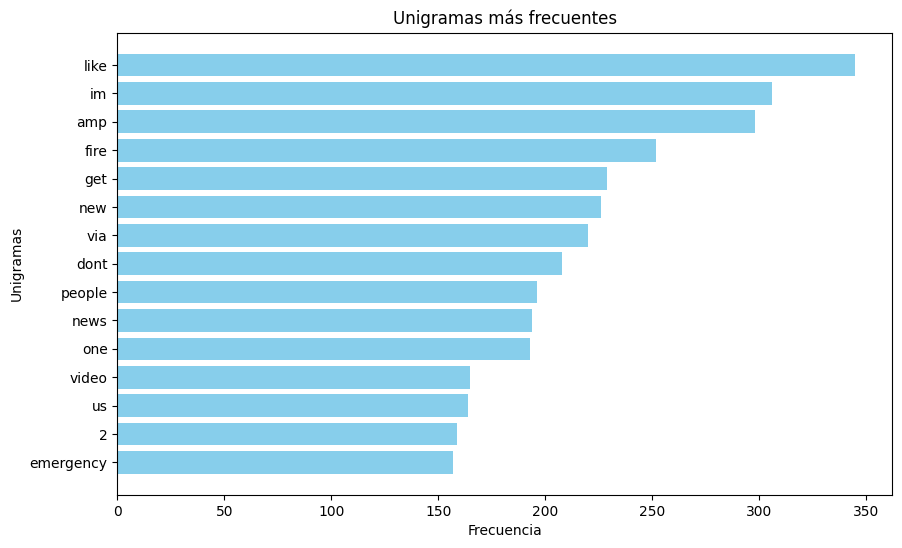

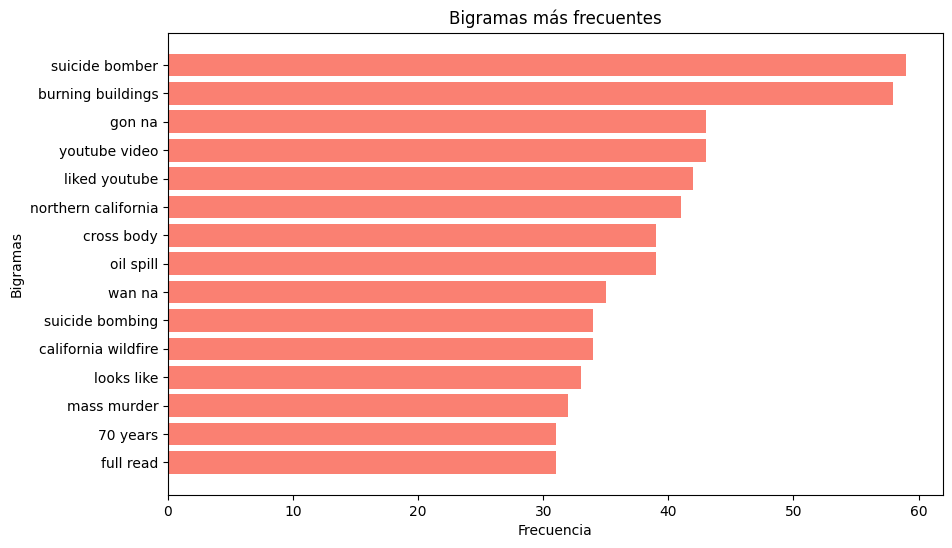

In [9]:
# Descargando recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Obteniendo una lista de stopwords en inglés
stop_words = set(stopwords.words('english'))

# Unigramas y bigramas
all_unigrams = []
all_bigrams = []

for text in train['text']:
    # Haciendo tokenización de las palabras en el texto
    tokens = word_tokenize(text.lower())
    
    # Filtrando stopwords y puntuación
    filtered_tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
    
    # Generando unigramas
    all_unigrams.extend(filtered_tokens)
    
    # Generando bigramas
    bi_grams = list(bigrams(filtered_tokens))
    all_bigrams.extend(bi_grams)

# Contando frecuencia de unigramas y bigramas
unigram_freq = Counter(all_unigrams)
bigram_freq = Counter(all_bigrams)

# Obteniendo los 10 unigramas y bigramas más frecuentes
top_unigrams = unigram_freq.most_common(15)
top_bigrams = bigram_freq.most_common(15)

# Separando los datos y las etiquetas para graficar
unigram_labels, unigram_counts = zip(*top_unigrams)
bigram_keywords, bigram_counts = zip(*top_bigrams)

# Graficando los unigramas más frecuentes
plt.figure(figsize=(10, 6))
plt.barh(unigram_keywords, unigram_counts, color='skyblue')
plt.xkeyword('Frecuencia')
plt.ykeyword('Unigramas')
plt.title('Unigramas más frecuentes')
plt.gca().invert_yaxis()  # Invertiendo el eje y para que los más frecuentes estén arriba
plt.show()

# Graficando los bigramas más frecuentes
plt.figure(figsize=(10, 6))

# Desempaquetando los pares de bigramas para etiquetas y valores separados
bigram_keywords = [f"{bg[0]} {bg[1]}" for bg in bigram_keywords]  
plt.barh(bigram_keywords, bigram_counts, color='salmon')
plt.xkeyword('Frecuencia')
plt.ykeyword('Bigramas')
plt.title('Bigramas más frecuentes')
plt.gca().invert_yaxis()  # Invertiendo el eje y para que los más frecuentes estén arriba
plt.show()


#### Creando un modelo preliminar de predicción.

c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Exactitud del modelo: 0.8614576493762311
Informe de clasificación:
                       precision    recall  f1-score   support

              ablaze       1.00      1.00      1.00         9
            accident       1.00      0.69      0.82        13
          aftershock       0.43      0.60      0.50         5
  airplane20accident       1.00      1.00      1.00         6
           ambulance       1.00      0.90      0.95        10
         annihilated       1.00      1.00      1.00         9
        annihilation       1.00      0.88      0.93         8
          apocalypse       0.67      0.67      0.67         3
          armageddon       1.00      0.90      0.95        10
                army       0.89      1.00      0.94         8
               arson       0.67      1.00      0.80         4
            arsonist       0.00      0.00      0.00         9
              attack       1.00      0.80      0.89        10
            attacked       0.92      1.00      0.96        11
 

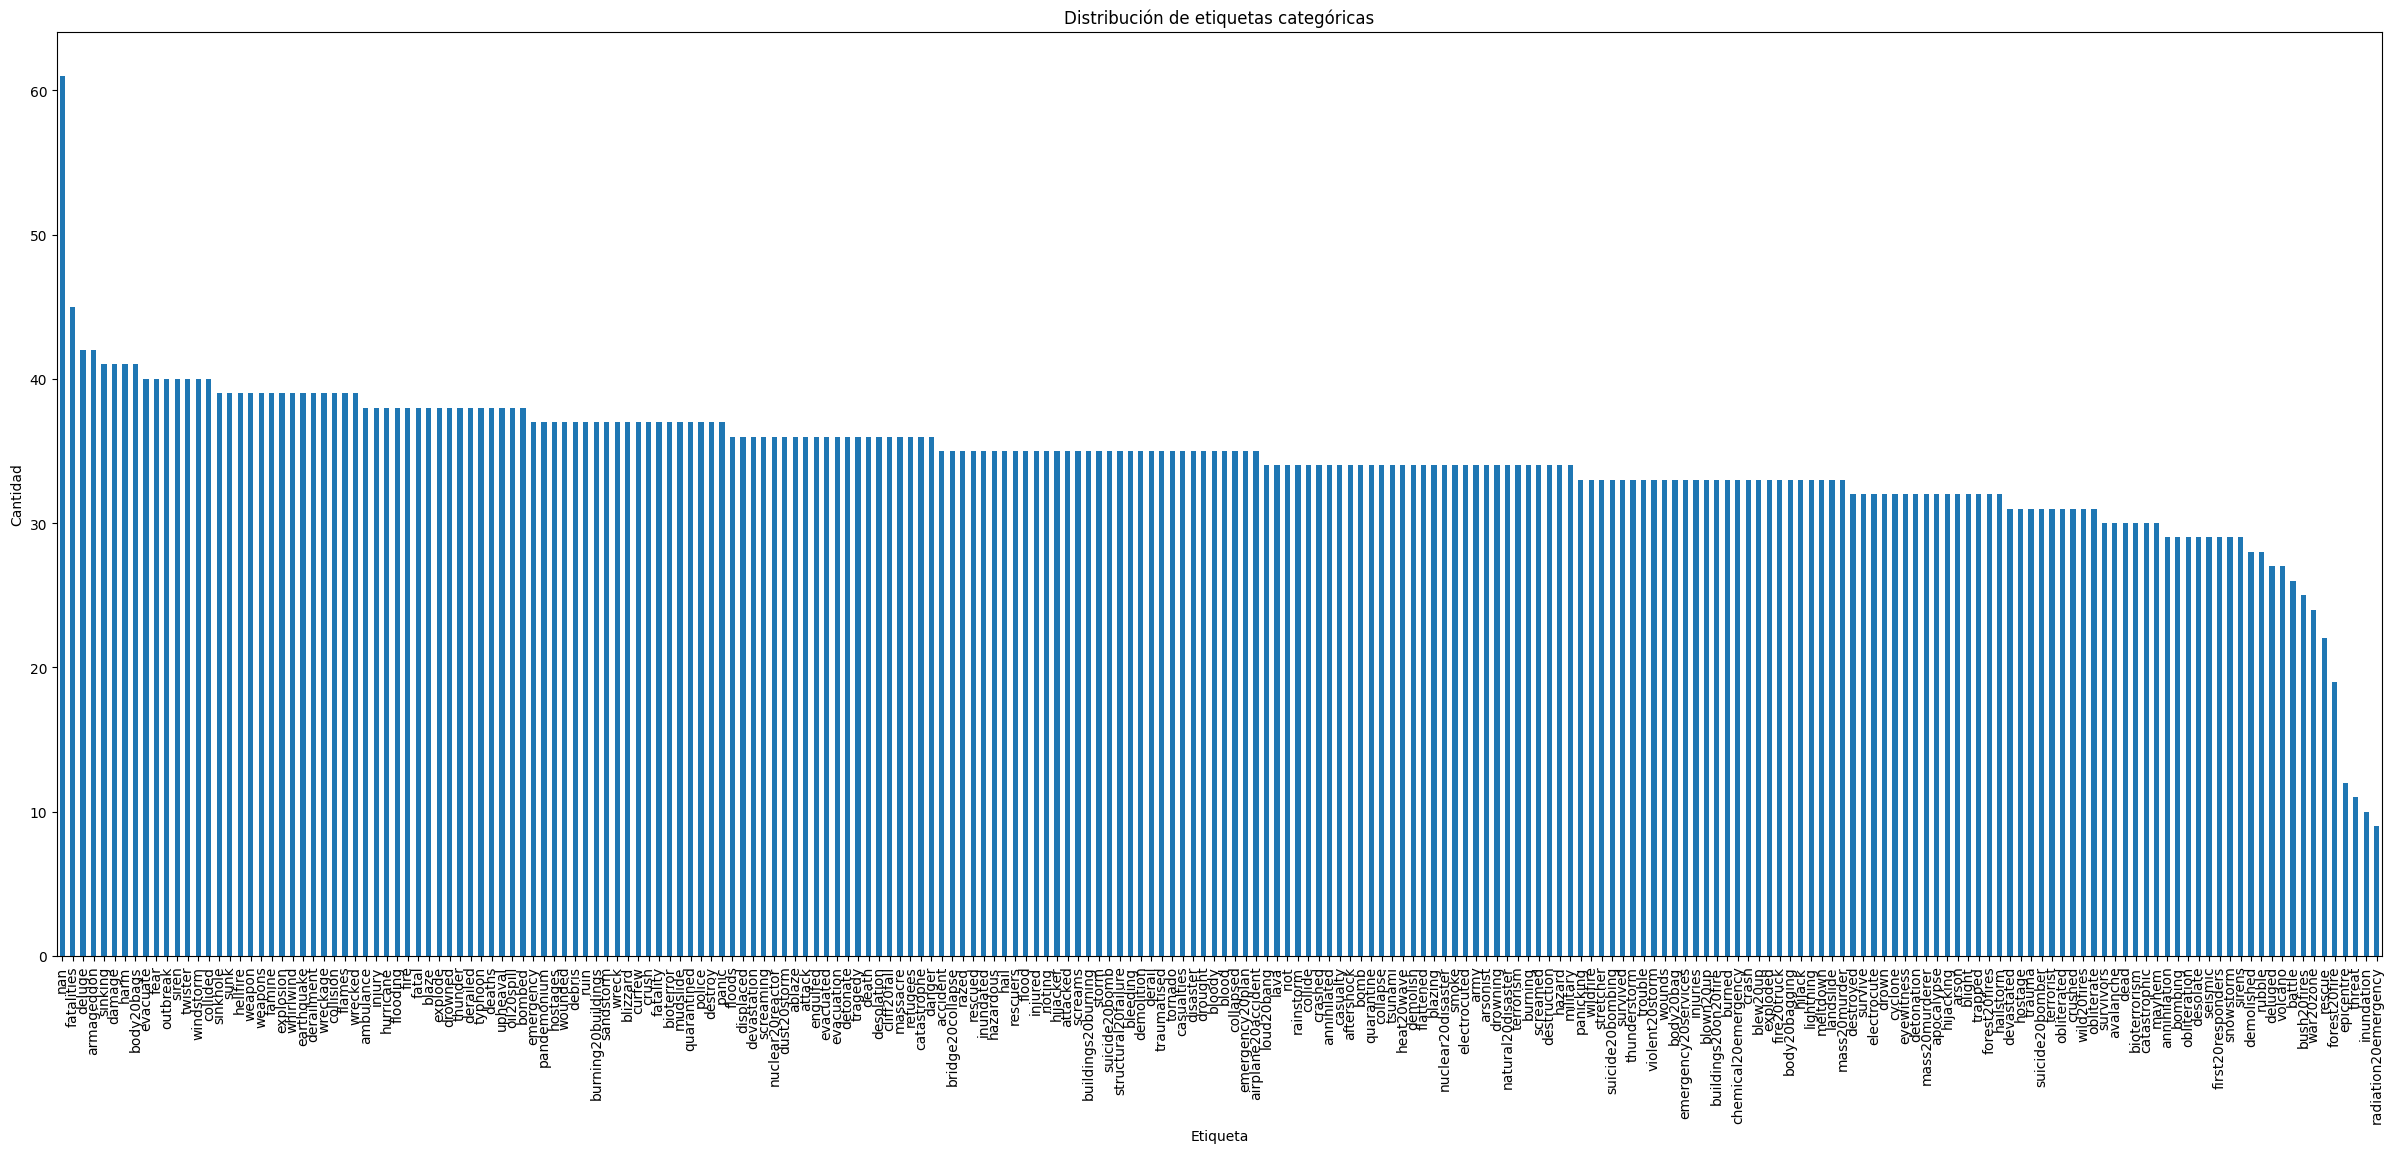

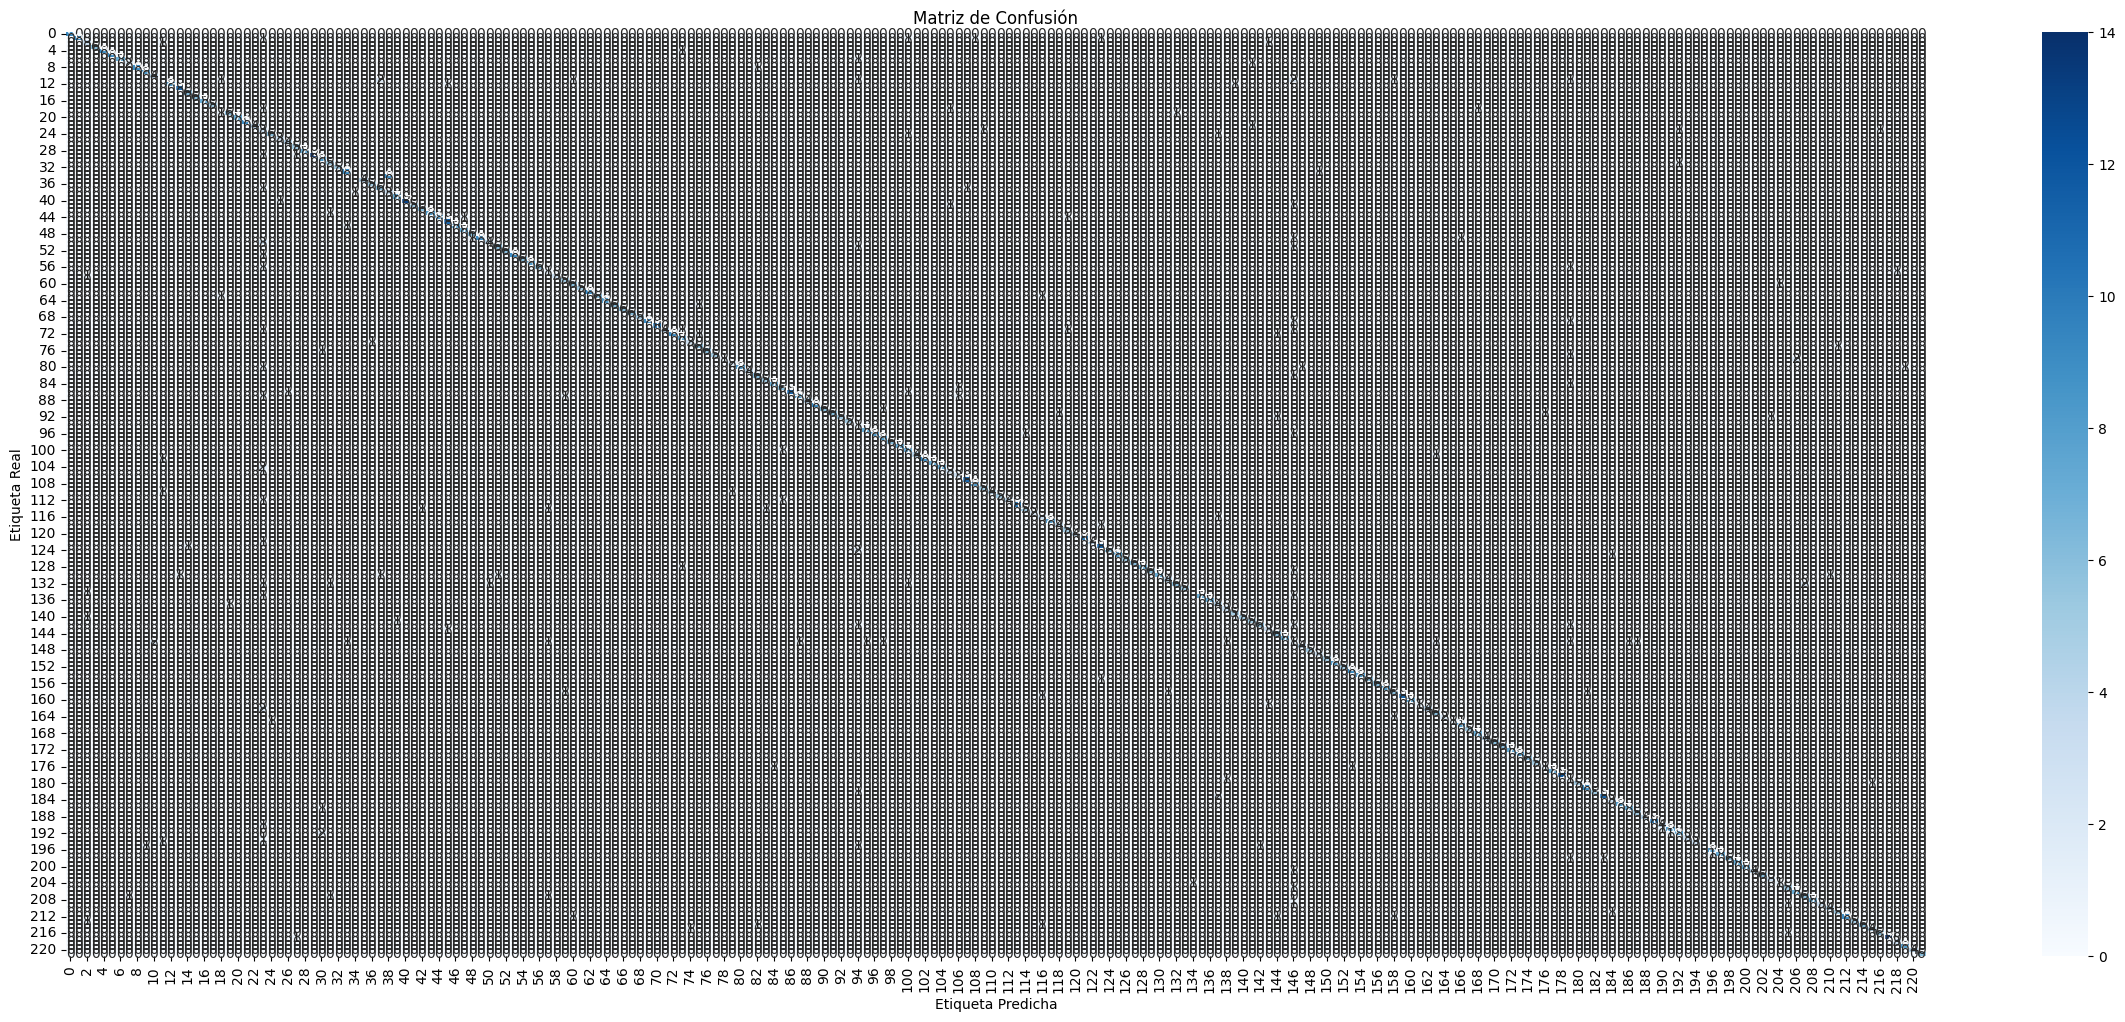

In [11]:
# Definiendo las características (X) y las etiquetas (y)
X = train['text']  # Usando la columna "text" como características
y = train['keyword']  # Usando la columna "keyword" como etiquetas

# Dividiendo el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorizando el texto utilizando TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # Características
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Entrenando el modelo de Bosques Aleatorios
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_vectorized, y_train)

# Predeciendo etiquetas en el conjunto de prueba
y_pred = model.predict(X_test_vectorized)

# Evaluando el modelo
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Exactitud del modelo:", accuracy)
print("Informe de clasificación:\n", classification_rep)

# Visualizando la distribución de etiquetas categóricas
plt.figure(figsize=(30, 12))
keyword_counts = train['keyword'].value_counts()
keyword_counts.plot(kind='bar')
plt.xkeyword('Etiqueta')
plt.ykeyword('Cantidad')
plt.title('Distribución de etiquetas categóricas')
plt.xticks(rotation=90)
plt.show()

# Creando la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizando de la matriz de confusión utilizando seaborn
plt.figure(figsize=(30, 12))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xkeyword('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()